# Word Embeddings em um Dataset Aberto

## Terceiro Exercício Prático


Neste TP você deve explorar e criar os embeddings utilizando uma base de dados de sua preferência. Uma sugestão para encontrar bases interessantes seria a partir das competições do [Kaggle](https://www.kaggle.com/).

Para essa prática, solicito que o aluno prepare a base de dados e gere os embeddings utilizando obrigatoriamente o algoritmo Word2Vec. Dependendo do contexto da base, você pode utilizar o Doc2Vec em vez do Word2Vec ou ambos. 

As 3 etapas descritas abaixo devem ser seguidas obrigatoriamente:

1. Preparação da base de dados assim como visto na prática anterior.
2. Execução do Modelo Word2Vec usando o Gensim, ou outra implementação similar.
3. Teste do seu embedding assim como foi realizado na [demo](https://github.com/gesteves91/nlp/blob/master/notebooks/06-word2vec.ipynb).


Para o trabalho foi capturado os tweets sobre o ex-presidente Lula no dia em que recebeu autorização para deixar a cadeia. Especificamos o dia 08/11/2019 (data em que ele saiu), restringindo a localização na região de Belo Horizonte, em um raio de 10.000 km.

In [1]:
# bibliotecas
import numpy as np
import pandas as pd
import tweepy
import nltk
import demoji
import re
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [ ]:
# leitura das chaves 
with open('twitter-tokens.txt', 'r') as tfile:
    consumer_key = tfile.readline().strip('\n')
    consumer_secret = tfile.readline().strip('\n')
    access_token = tfile.readline().strip('\n')
    access_token_secret = tfile.readline().strip('\n')

In [ ]:
# variaveis para fazer o login
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

In [ ]:
# Query passando a busca e excluindo os retweets.
query_search = 'Lula' + '-filter:retweets'

#Gerando o cursor de busca.
cursor_tweets = tweepy.Cursor(api.search, q=query_search, tweet_mode='extended',lang="pt", 
                              since= "2019-11-07", until= "2019-11-09",
                              geocode='-19.9026615,-44.1041363,10000km').items()

In [ ]:
tw = []
for tweet in cursor_tweets:
    tw.append([tweet.created_at, tweet.full_text])

In [ ]:
df = pd.DataFrame(tw, columns=['Data','Tweet'])

In [ ]:
# Convertendo a data
df['Data'] = pd.to_datetime(df['Data'])
df['Data'] = df['Data'].dt.strftime('%d-%m-%Y')

In [ ]:
# Salvando em um arquivo csv.
df.to_csv('Trump.csv')

In [ ]:
df.shape

# Preparando a base de dados

In [2]:
df_bh = pd.read_csv('bh3.csv')

In [3]:
df_bh.shape

(6750, 3)

In [4]:
df_bh.head()

,Unnamed: 0,Data,Tweet
0,0,08-11-2019,Lula virou comediante na cadeia e saiu fazendo...
1,1,08-11-2019,Hoj o Lula transa com o super pênis dele https...
2,2,08-11-2019,@ana_claudiinha até o Lula tá beijando e você ...
3,3,08-11-2019,@ggreenwald Bravo! Bravo! Você tem grande impo...
4,4,08-11-2019,"Vou me ausentar desse site, quando pararem de ..."


In [5]:
df = df_bh[['Data', 'Tweet']].copy()

# Removendo stopwords

In [6]:
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

In [7]:
def remov_stopwords(text):
    text = text.lower()
    palavras = [i for i in text.split() if not i in stopwords]
    return (" ".join(palavras))

In [8]:
df['Tweet'] = df.apply(lambda row: remov_stopwords(row['Tweet']), axis=1)

# Removendo links

In [9]:
df['Tweet'] = df.apply(lambda x: re.sub(r"http\S+", "", x['Tweet']), axis=1)

# Substituindo emojis

In [11]:
# demoji.download_codes()
# A funcação faz a leitura do emoji e converte ele para o tipo texto

def remove_emoji(emoji):
    rep = demoji.findall(emoji)
    re = demoji.replace(emoji)
    if any(rep) == False:
        return re
    else:
        for x in rep:
            text = re + rep[x]
            return text.replace("  ", " ")

In [12]:
df['Tweet'] = df.apply(lambda x: remove_emoji(x['Tweet']), axis=1)

# Tokenização

In [13]:
# Tokenizando as frases.
df['Tokens'] = df.apply(lambda x: word_tokenize(x['Tweet'], language='portuguese'), axis=1)

In [14]:
# Removendo pontuação
pontos = list(punctuation)

def remove_pont(tweets):
    return(x for x in tweets if not x in pontos)

In [15]:
df['Tokens'] = df.apply(lambda x: remove_pont(x['Tokens']), axis=1)

# Lematização

In [16]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [17]:
# Lemmatizando os tweets.
def lemmatize_func(mylist):
    return [lemmatizer.lemmatize(w) for w in mylist]

df['Tokens'] = df.apply(lambda row: lemmatize_func(row['Tokens']), axis=1)

# Stemming

In [18]:
stemming = nltk.stem.RSLPStemmer()

In [19]:
def stemming_func(mylist):
    return [stemming.stem(w) for w in mylist]

df['Tokens'] = df.apply(lambda row: stemming_func(row['Tokens']), axis=1)

# Nuvem de palavras

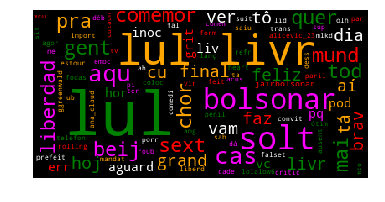

In [20]:
from wordcloud import WordCloud

mapa_cores = ListedColormap(['orange', 'white','green', 'red', 'magenta'])
nuvem = WordCloud(background_color= 'black', colormap= mapa_cores, max_words= 100)
text = str(df['Tokens'])
nuvem.generate(text)
plt.axis("off")
plt.imshow(nuvem)

# Word2Vec com Gensim

In [21]:
# imports das bibliotecas
import gzip
import gensim 
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [22]:
documents = df['Tokens']

In [23]:
documents.value_counts()

[lul, livr]                                                                                                                           52
[lul, sai, sext]                                                                                                                      24
[chor, livr, lul]                                                                                                                     20
[lul, tá, livr, babac]                                                                                                                18
[lul, tá, solt, babac]                                                                                                                13
[lul, sai, sext, nad]                                                                                                                 10
[lul]                                                                                                                                  7
[lul, livr, caralh]                      

In [24]:
# Treinando o modelo
model = gensim.models.Word2Vec(documents, size=150, window=10, min_count=2, workers=10)
model.train(documents,total_examples=len(documents),epochs=10)

2019-11-19 06:51:55,752 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-11-19 06:51:55,753 : INFO : collecting all words and their counts
2019-11-19 06:51:55,754 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-19 06:51:55,808 : INFO : collected 8228 word types from a corpus of 73082 raw words and 6750 sentences
2019-11-19 06:51:55,810 : INFO : Loading a fresh vocabulary
2019-11-19 06:51:55,834 : INFO : effective_min_count=2 retains 3615 unique words (43% of original 8228, drops 4613)
2019-11-19 06:51:55,837 : INFO : effective_min_count=2 leaves 68469 word corpus (93% of original 73082, drops 4613)
2019-11-19 06:51:55,879 : INFO : deleting the raw counts dictionary of 8228 items
2019-11-19 06:51:55,887 : INFO : sample=0.001 downsamples 50 most-common words
2019-11-19 06:51:55,890 : INFO : downsampling leaves estimated 55273 word corpus (80.7% of prior 68469)
2019-11-19 06:51:55,915 : INFO : estimated required mem

2019-11-19 06:51:58,115 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-19 06:51:58,117 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-19 06:51:58,202 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-19 06:51:58,209 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-19 06:51:58,232 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-19 06:51:58,247 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-19 06:51:58,263 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-19 06:51:58,291 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-19 06:51:58,294 : INFO : EPOCH - 2 : training on 73082 raw words (55293 effective words) took 0.3s, 170594 effective words/s
2019-11-19 06:51:58,515 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-11-19 06:51:58,537 : INFO : worker thread f

2019-11-19 06:52:00,856 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-11-19 06:52:00,880 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-19 06:52:00,896 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-19 06:52:00,923 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-19 06:52:00,934 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-19 06:52:00,940 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-19 06:52:00,965 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-19 06:52:00,997 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-19 06:52:01,013 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-19 06:52:01,017 : INFO : EPOCH - 10 : training on 73082 raw words (55282 effective words) took 0.3s, 166429 effective words/s
2019-11-19 06:52:01,024 : INFO : training on a 

(552634, 730820)

In [25]:
model.wv['lul']

array([ 0.19004938, -0.2468242 ,  0.33999112,  0.45673913,  0.04662987,
        0.59906435,  0.22627129,  0.15996377,  0.03319811, -0.41599324,
        0.15831944,  0.36628854,  0.0680826 ,  0.10092372,  0.05860528,
        0.0927552 , -0.21175706, -0.2724616 ,  0.31260818,  0.3164023 ,
        0.3175581 , -0.14342178,  0.12862164, -0.5743546 ,  0.10713418,
        0.04496363,  0.00796609, -0.4300673 ,  0.04472861, -0.22745267,
        0.34652156,  0.1130705 ,  0.12194464, -0.07701173,  0.15316913,
       -0.09116344, -0.5238816 ,  0.15544699,  0.40624833, -0.21858549,
       -0.01878553, -0.2101924 , -0.6813895 , -0.30756927, -0.13875073,
       -0.493304  ,  0.02883871,  0.5402538 , -0.20272131,  0.6778529 ,
        0.17372929, -0.05541781, -0.04010838,  0.5715897 ,  0.5023904 ,
        0.4425064 , -0.23644872,  0.23021819,  0.10488051,  0.37575302,
        0.12899944,  0.28493658, -0.2814004 , -0.64422435,  0.13212502,
       -0.42434782,  0.0471498 , -0.02267922, -0.10373554,  0.05

In [26]:
# Procurando palavras semelhantes
w1 = ['livr']
model.wv.most_similar(positive=w1)

2019-11-19 06:52:02,326 : INFO : precomputing L2-norms of word weight vectors


[('tbm', 0.9334547519683838),
 ('abrahamweint', 0.9323699474334717),
 ('bolsominiom', 0.9317895174026489),
 ('marciolimaf8', 0.9286508560180664),
 ('mig', 0.9282485246658325),
 ('relembr', 0.9259366393089294),
 ('doend', 0.9248038530349731),
 ('simmm', 0.9202380180358887),
 ('barretorec', 0.9164183735847473),
 ('carlux', 0.9126714468002319)]

In [27]:
# vamos ver as 5 palavras mais similares a 'lul'
w1 = ["lul"]
model.wv.most_similar(positive=w1, topn=5)

[('tcc', 0.79767245054245),
 ('levant', 0.7965827584266663),
 ('loj', 0.7905645370483398),
 ('bich', 0.7866742610931396),
 ('falt', 0.7858394384384155)]

In [28]:
# vamos ver as 5 palavras mais similares a 'sext'
w1 = ["sext"]
model.wv.most_similar (positive=w1,topn=6)

[('bebemor', 0.9669697880744934),
 ('boc', 0.9476513862609863),
 ('beij', 0.9449583888053894),
 ('hj', 0.9371660947799683),
 ('noil', 0.9355956315994263),
 ('noiv', 0.9338770508766174)]

In [29]:
# palavras mais relacionadas 
w1 = ['lul', 'sai', 'sext']
model.wv.most_similar(positive=w1,topn=10)

[('noiv', 0.974556565284729),
 ('noil', 0.9724412560462952),
 ('feir', 0.9688636064529419),
 ('sexta-f', 0.9636664390563965),
 ('ate', 0.9613667130470276),
 ('23min', 0.9598232507705688),
 ('united', 0.9583615064620972),
 ('beijin', 0.9580140113830566),
 ('hj', 0.9552854299545288),
 ('boc', 0.953216552734375)]

# Similaridade entre palavras

In [30]:
# similaridade de duas palavras diferentes
model.wv.similarity(w1="lul", w2="liv")

0.72669566

In [31]:
# similaridades de duas palavras idênticas
model.wv.similarity(w1="lul", w2="lul")

1.0

In [32]:
# similaridade de duas palavras opostas
model.wv.similarity(w1="lul", w2="bolsonar")

0.4367652

In [33]:
# itens que nao se relacionam
model.wv.doesnt_match(["lul","bolsonar","liv"])

/home/rafael/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'bolsonar'

In [34]:
for i, word in enumerate(documents):
    if i == 10:
        print(word)

['``', 'agor', 'quer', 'ver', 'bolsonar', 'ter', 'cu', 'quer', 'ver', 'ter', 'cu', 'pro', 'lul', "''", 'fras', 'solt', 'mãe']


In [35]:
# Recuperando o vocabulario
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

lul
vir
cade
saiu
faz
ótim
pi
hoj
trans
sup


# Análise de sentimentos

In [36]:
from textblob import TextBlob as tb

In [37]:
# variavel para armazenar polaridade
analysis = None
tweets = []

In [38]:
public_tweets = df['Tweet']

In [39]:
for tweet in public_tweets:
    analysis = tb(tweet)
    polarity = analysis.sentiment.polarity
    tweets.append(polarity)
    print(polarity)

0.0
0.3333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.3
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.0
0.4166666666666667
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5859375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
-0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
-0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.16666666666666666
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.15
0.0
0.0
0.0
0.8
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03333333333333333
0.0
0.0
0.2
0.0
0.0
0.0
0.15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.05
0.0
0.0
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.13636363636363635
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0546875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2857142857142857
0.0
0.5
-0.05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.8
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.234375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.13636363636363635
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05208333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.25
0.0
0.0
0.0
0.0
0.0
0.6
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6
0.0
0.0
0.0
0.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03333333333333333
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.

In [40]:
print("Média de sentimento:", str(np.mean(tweets)))

Média de sentimento: 0.01556439677863289


# Visualizando a incorporação das palavras

In [41]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import random

In [42]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for i, word in enumerate(model.wv.vocab):
        if i == 500:
            break
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):    

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)